## 8.1 Simple Exponential Smoothing
Suitable for forecasting data with no clear trend or seasonal pattern.

In [ ]:
%load_ext autoreload
%autoreload 2

### Weighted average form
The forecast at time $T+1$ is given to a weighted average between the most recent observation $y_T$ and the previous forecast $\hat{y}_{T|T-1}$:
$$
\hat{y}_{T+1|T} = \alpha y_T + (1-\alpha)\hat{y}_{T|T-1},
$$
where $0\le \alpha \le 1$ is the smoothing parameter. Similarly we can write the fitted values as 
$$
\hat{y}_{t+1|t} = \alpha y_t + (1-\alpha)\hat{y}_{t|t-1},
$$
for $t=1,\ldots,T$. 

Let the first fitted value at time 1 be denoted by $\mathcal{l}_0$ (which we estimate), then after substituting into successive equations, we get
$$
\hat{y}_{T+1|T} = \sum_{j=0}^{T-1}\alpha(1-\alpha)^j y_{T-j} + (1-\alpha)^Tl_0.
$$
The last term becomes tiny for large $T$.

### Component form
$$
\begin{align*}
\text{Forecast equation} &\quad \hat{y}_{t+h|t} = \ell_t \\
\text{Smoothing equation} &\quad \ell_t = \alpha y_t + (1-\alpha)\ell_{t-1}
\end{align*},
$$
where $\mathcal{l}_t$ represents the *current smoothed level** of the time series. The forecast value at time $t+1$ is the estimated level at time $t$. The smoothing equation for the level (level equation) gives the estimated level of the series at each period $t$. 

### Flat forecasts
Simple exponential smoothing has a "flat" forecast function:
$$
\hat{y}_{T+h|T} = \hat{y}_{T+1|T} = \ell_T, \quad h=2, 3,\ldots
$$
That is, all forecasts take the same value, equal to the last level component.

### Optimisation
The application of every exponential smoothing method requires the smoothing parameters and the initial values to be chosen. For simple exponential smoothing we need to select the values of $\alpha$ and $\ell_0$.

We can estimate them from the observed data by minimising the sum of the squared residuals (SSE). The residuals are specified as $e_t= y_t - \hat{t|t-1}$ for $t=1,\ldots,T$. Hence we find the values of the unknown parameters and the initial values that minimise
$$
SSE = \sum_{t=1}^T(y_t - \hat{y}_{t|t-1})^2 = \sum_{t=1}^T e_t^2.
$$
This is a non-linear optimisation problem, and we need to use an optimisation tool to solve it.

In [ ]:
import pandas as pd
import statsmodels.api as sm
import plotnine as p9
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.0)

In [8]:
import sys
sys.path.append('..')
from utils import compute, summarize, set_freq

In [4]:
global_economy = (pd.read_csv('../data/tsibbledata/global_economy.csv', parse_dates=['Year'])
    .rename(columns={'Year': 'Date'})
    .assign(Pop=lambda df: df['Population']/1.e6)
)

In [13]:
algeria_economy = (
    global_economy.query("Country == 'Algeria'")
    .set_index('Date', drop=False)
    .pipe(set_freq)
)

In [14]:
algeria_economy.head()

,Country,Code,Date,GDP,Growth,CPI,Imports,Exports,Population,Pop
Date,,,,,,,,,,
1960-01-01,Algeria,DZA,1960-01-01,2.723649e+09,NaN,NaN,67.143632,39.043173,11124888.0,11.124888
1961-01-01,Algeria,DZA,1961-01-01,2.434777e+09,-13.605441,NaN,67.503771,46.244557,11404859.0,11.404859
1962-01-01,Algeria,DZA,1962-01-01,2.001469e+09,-19.685042,NaN,20.818647,19.793873,11690153.0,11.690153
1963-01-01,Algeria,DZA,1963-01-01,2.703015e+09,34.313729,NaN,36.825515,24.684682,11985136.0,11.985136
1964-01-01,Algeria,DZA,1964-01-01,2.909352e+09,5.839413,NaN,29.439763,25.084059,12295970.0,12.295970


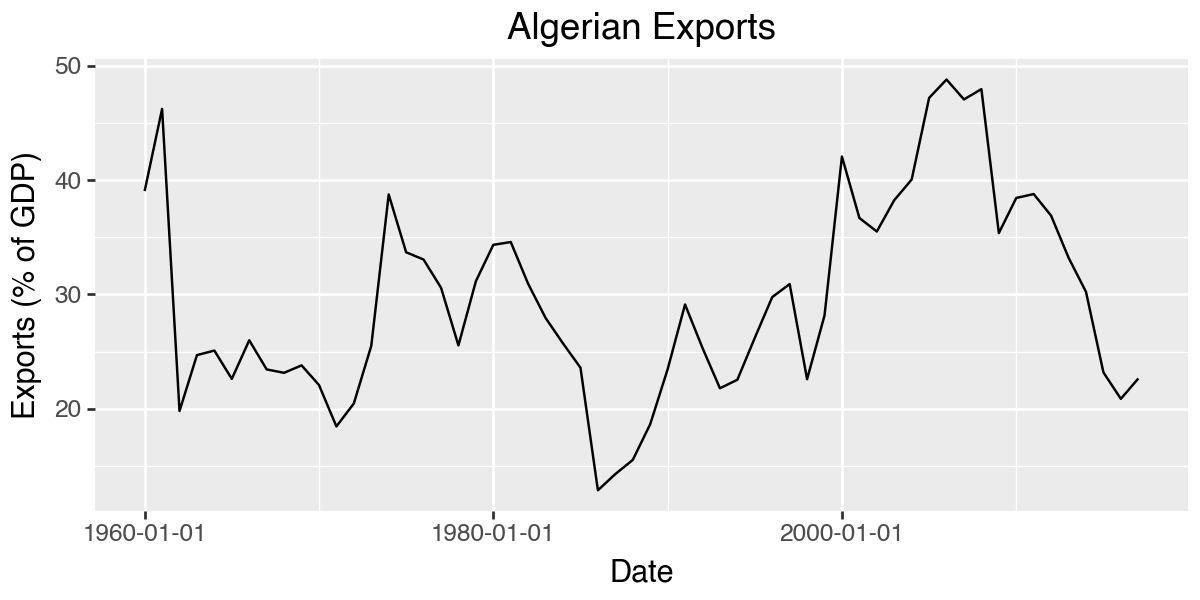

In [19]:
p9.ggplot(algeria_economy) + p9.aes(x='Date', y='Exports') + p9.geom_line() \
    + p9.labs(y='Exports (% of GDP)', title='Algerian Exports') \
    + p9.theme(figure_size=(6, 3))

In [20]:
Y = algeria_economy.Exports
X = Y.index
fit = sm.tsa.SimpleExpSmoothing(Y).fit()
fit.summary()

Dep. Variable:,Exports,No. Observations:,58
Model:,SimpleExpSmoothing,SSE,1995.536
Optimized:,True,AIC,209.217
Trend:,None,BIC,213.338
Seasonal:,None,AICC,209.972
Seasonal Periods:,None,Date:,"Wed, 20 Nov 2024"
Box-Cox:,False,Time:,11:47:28
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.8395372,alpha,True
initial_level,39.043173,l.0,False


In [23]:
def errorscale(percent):
    return stats.norm.isf((1-percent/100) / 2)

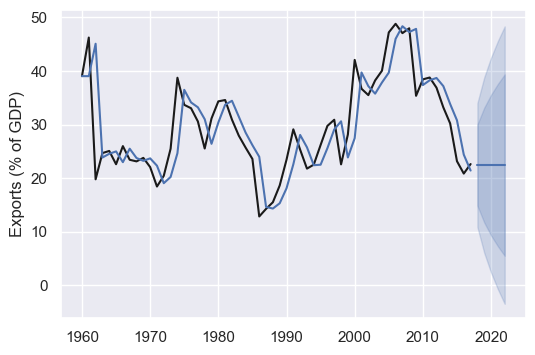

In [35]:
n_steps = 5
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(Y, 'k')

fitted = fit.fittedvalues
ax.plot(fit.fittedvalues)

fcast = fit.forecast(n_steps)
ax.plot(fcast, color='C0')

sigma = (Y - fitted).std()
dy = sigma * np.sqrt(1 + np.arange(len(fcast)))

crit_value_80 = errorscale(80)
crit_value_95 = errorscale(95)

ax.fill_between(fcast.index, fcast-crit_value_80*dy, fcast+crit_value_80*dy, color='C0', alpha=0.2)
ax.fill_between(fcast.index, fcast-crit_value_95*dy, fcast+crit_value_95*dy, color='C0', alpha=0.2)

ax.set(ylabel='Exports (% of GDP)')
plt.show();

We plot the forecasts for the period 2018-2022, and one-step-ahead fitted values alongside the data over the period 1960-2017. The prediction intervals show there is considerable uncertainty in the future exports over the five-year forecast period.

### Other notes
- `scipy.stats.norm.isf`: The `isf` method stands for "inverse survival function" (also known as the inverse complementary cumulative distribution function or quantile function) for the normal distribution.

- **Survival Function (SF)**: The survival function is the complement of the cumulative distribution function (CDF). For a given value x, the survival function `SF(x)` is defined as `1 - CDF(x)`. It represents the probability that a random variable from the distribution is greater than `x`.
- **Inverse Survival Function (ISF)**: The inverse survival function is the inverse of the survival function. For a given probability `p`, `isf(p)` returns the value x such that the probability of the random variable being greater than `x` is `p`.
Usage:
The `scipy.stats.norm.isf` method is used to find the quantile (or critical value) corresponding to a given upper-tail probability for the normal distribution.
